# Pairs-Trading in the Automotive Industry
This notebook aims to research possible highly correlated and cointegrated assets in the automotive industry for use in pairs trading, before conducting backtests to see their performance.

## Preparations

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

## 1. Universe and Stock Selection
### 1.1 Retrieving data
From the Consumer Discretionary sector, we filter out a list of automotive stocks, both traded in NYSE and NASDAQ. We then attain their tickers and store it in a list.

In [2]:
NYSE = pd.read_excel('NYSE_Auto.xls')
NASDAQ = pd.read_excel('NASDAQ_Auto.xls')

# Remove nan value
NYSE = NYSE[:-1]
NASDAQ = NASDAQ[:-1]

In [3]:
NYSE

,S.No.,Company Name,Ticker,Country
0,1.0,Ferrari N.V.,RACE,Italy
1,2.0,Fisker Inc.,FSR,USA
2,3.0,Ford Motor Company,F,USA
3,4.0,General Motors Company,GM,USA
4,5.0,Honda Motor Company Ltd.,HMC,Japan
5,6.0,Oshkosh Corporation,OSK,USA
6,7.0,Stellantis N.V.,STLA,United Kingdom
7,8.0,Tata Motors Ltd,TTM,India
8,9.0,Toyota Motor Corporation,TM,Japan
9,10.0,XPeng Inc.,XPEV,China


In [4]:
NASDAQ

,S.No.,Company,Ticker,Country
0,1.0,Electrameccanica Vehicles Corp. Ltd.,SOLO,Canada
1,2.0,Ideanomics Inc.,IDEX,USA
2,3.0,Kandi Technologies Group Inc,KNDI,China
3,4.0,Li Auto Inc.,LI,China
4,5.0,Lordstown Motors Corp.,RIDE,USA
5,6.0,Nikola Corporation,NKLA,USA
6,7.0,Niu Technologies,NIU,China
7,8.0,PACCAR Inc.,PCAR,USA
8,9.0,Tesla Inc.,TSLA,USA
9,10.0,The Shyft Group Inc.,SHYF,USA


In [5]:
# Converting tickers to a list
tickers = NASDAQ['Ticker'].tolist() + NYSE['Ticker'].tolist()
tickers

['SOLO',
 'IDEX',
 'KNDI',
 'LI',
 'RIDE',
 'NKLA',
 'NIU',
 'PCAR',
 'TSLA',
 'SHYF',
 'WKHS',
 'RACE',
 'FSR',
 'F',
 'GM',
 'HMC',
 'OSK',
 'STLA',
 'TTM',
 'TM',
 'XPEV']

Here, we get the historical data for automobiles in the past 10 years. We split the data set into a test and training set

In [6]:
# Training set
start = '2012-01-01'
end = '2022-04-01'
prices = yf.download(tickers, start=start, end=end)['Adj Close']

train = np.arange(0, 1260) # trading days in 5 years
test = np.arange(train.shape[0], prices.shape[0])

[*********************100%***********************]  21 of 21 completed


### 1.2 Cleaning up data
As there are a couple tickers with insuffcient historical data, we remove them from our universe. They present insufficient data and which might result in data-snooping bias during backtesting, hence their removal.

In [7]:
prices = prices.dropna(axis=1)
prices

,F,GM,HMC,IDEX,KNDI,OSK,PCAR,SHYF,STLA,TM,TSLA,TTM,WKHS
Date,,,,,,,,,,,,,
2012-01-03,7.419180,16.269415,31.190945,4.50,3.51,19.807070,27.033707,4.416613,2.012491,59.586105,5.616000,17.598068,4.90
2012-01-04,7.532501,16.346703,31.449707,4.50,3.18,20.239962,26.929203,4.355271,2.141897,60.157532,5.542000,18.258844,4.30
2012-01-05,7.725813,17.135057,31.728374,4.50,3.12,20.275305,28.120623,4.460430,2.141897,60.324554,5.424000,18.560080,3.10
2012-01-06,7.805804,17.714725,31.977188,4.50,3.19,20.416655,27.967339,4.434141,2.141897,60.227856,5.382000,18.511494,4.50
2012-01-09,7.865797,17.652895,31.897566,4.50,3.36,21.035080,28.301783,4.311456,2.159747,60.148727,5.450000,18.589233,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,16.361143,43.650002,28.440001,0.92,2.94,107.084534,88.615578,38.126133,14.681528,178.429993,1010.640015,28.400000,4.33
2022-03-28,16.559822,44.220001,28.200001,0.95,3.03,105.600845,88.944267,38.854530,14.737070,177.850006,1091.839966,28.540001,4.43
2022-03-29,17.632683,46.259998,29.049999,1.04,3.32,108.349152,90.587685,40.141701,15.810877,184.809998,1099.569946,29.150000,4.96


### 1.3 Finding Potential Pairs
We find the spearman correlation coefficient here in our universe to determine which stocks are highly correlated to one another, as visualised via a heatmap. The coefficients are calculated using the training set (first 5 years of historical data). Afterwards, we selectively pick out pairs that have a correlaton coefficient >= 0.7.

In [8]:
# Correlation heatmap
def correlation_matrix(df, is_plot=False):
    
    # Get feature correlations and transform to dataframe
    correlated = df.corr(method='spearman')

    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(correlated, cmap='RdYlGn', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(correlated)), correlated.columns, rotation='vertical')
        plt.yticks(range(len(correlated)), correlated.columns);
        plt.suptitle('Spearman Correlation Heat Map', fontsize=15, fontweight='bold')
        plt.show()

    return correlated

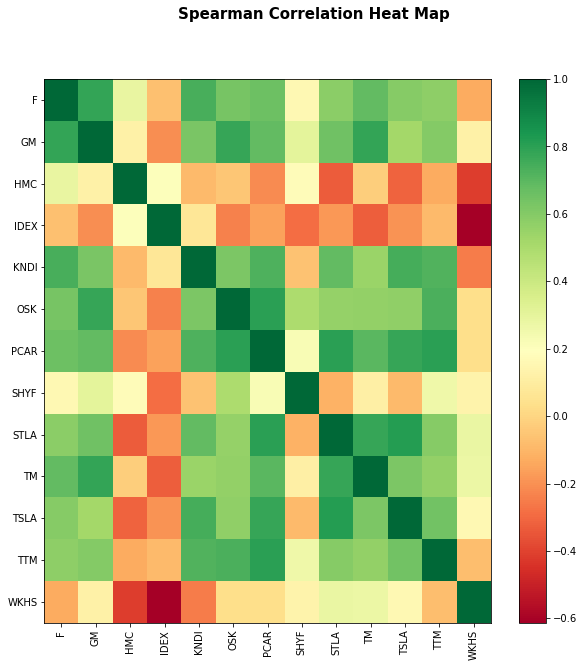

In [9]:
corr = correlation_matrix(prices.iloc[train], is_plot=True)

In [10]:
corr

,F,GM,HMC,IDEX,KNDI,OSK,PCAR,SHYF,STLA,TM,TSLA,TTM,WKHS
F,1.000000,0.784820,0.284868,-0.070756,0.737589,0.632293,0.653886,0.159059,0.579756,0.682592,0.590615,0.577657,-0.129881
GM,0.784820,1.000000,0.120266,-0.208207,0.623883,0.775980,0.681193,0.301410,0.651268,0.782160,0.515234,0.601950,0.122189
HMC,0.284868,0.120266,1.000000,0.202403,-0.084163,-0.045946,-0.212155,0.176550,-0.330500,-0.024003,-0.312986,-0.130448,-0.416786
IDEX,-0.070756,-0.208207,0.202403,1.000000,0.072769,-0.237404,-0.157875,-0.289869,-0.180033,-0.327816,-0.192261,-0.085558,-0.612764
KNDI,0.737589,0.623883,-0.084163,0.072769,1.000000,0.619876,0.726769,-0.063004,0.680902,0.545587,0.744282,0.720869,-0.248066
OSK,0.632293,0.775980,-0.045946,-0.237404,0.619876,1.000000,0.800140,0.494572,0.553300,0.560991,0.568321,0.734513,0.034319
PCAR,0.653886,0.681193,-0.212155,-0.157875,0.726769,0.800140,1.000000,0.222161,0.799574,0.702295,0.774390,0.800064,0.030455
SHYF,0.159059,0.301410,0.176550,-0.289869,-0.063004,0.494572,0.222161,1.000000,-0.109985,0.113240,-0.089241,0.259842,0.136615
STLA,0.579756,0.651268,-0.330500,-0.180033,0.680902,0.553300,0.799574,-0.109985,1.000000,0.774553,0.813897,0.593299,0.281690
TM,0.682592,0.782160,-0.024003,-0.327816,0.545587,0.560991,0.702295,0.113240,0.774553,1.000000,0.620198,0.561679,0.270137


In [11]:
# Unstack correlation matrix and get pairs with corr coefficient >= 0.8
corr_unstacked = corr.unstack()
sorted_corr = corr_unstacked.sort_values(kind='quicksort')

pairs = sorted_corr[np.logical_and(sorted_corr < 1.0, sorted_corr >= 0.7)]
pairs

TM    PCAR    0.702295
PCAR  TM      0.702295
KNDI  TTM     0.720869
TTM   KNDI    0.720869
PCAR  KNDI    0.726769
KNDI  PCAR    0.726769
OSK   TTM     0.734513
TTM   OSK     0.734513
KNDI  F       0.737589
F     KNDI    0.737589
TSLA  KNDI    0.744282
KNDI  TSLA    0.744282
PCAR  TSLA    0.774390
TSLA  PCAR    0.774390
TM    STLA    0.774553
STLA  TM      0.774553
GM    OSK     0.775980
OSK   GM      0.775980
GM    TM      0.782160
TM    GM      0.782160
GM    F       0.784820
F     GM      0.784820
PCAR  STLA    0.799574
STLA  PCAR    0.799574
TTM   PCAR    0.800064
PCAR  TTM     0.800064
OSK   PCAR    0.800140
PCAR  OSK     0.800140
STLA  TSLA    0.813897
TSLA  STLA    0.813897
dtype: float64

### 1.4 Testing for Cointegration (Engle-Granger)
Out of the highly-correlated pairs we have found, we attempt to find cointegrated pairs of stocks as their market value as a pair will be stationary. This stationarity implies that the pair's market value will not diverge too much, making it a suitable candidate for a mean-reversion strategy. 

For this, we conduct the Engle-Granger test on all pairs that we obtained above.

In [12]:
# Engle-granger test
def engle_granger(asset1, asset2, prices):
    _, p, _ = coint(prices[asset1], prices[asset2])
    
    if p < 0.05:
        print(f'{asset1} and {asset2} are cointegrated')
        
pairs = pairs.index
pairs = pairs.tolist()
for asset1, asset2 in pairs:
    engle_granger(asset1, asset2, prices)
    

GM and OSK are cointegrated
GM and TM are cointegrated


#### 1.4 Choosing a final pair
To choose a final pair, we pick the pair that has a higher correlation coefficient value as their prices are more likely to move together. Hence, we pick GM and TM.

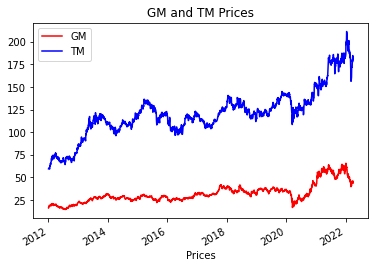

In [13]:
prices['GM'].plot(c='r')
prices['TM'].plot(c='b')
plt.legend()
plt.xlabel('Prices')
plt.title('GM and TM Prices');

## 2. Strategy

#### 2.1 Determing Hedge Ratio
As the order of assets in the Engle-Granger test matters, we hence use GM as our target, and will be performing regression of GM against TM to find the hedge ratio for our spread. This will all be done on the training set.

In [14]:
model = sm.OLS(prices.iloc[train]['GM'], prices.iloc[train]['TM']).fit() 

In [15]:
hedge = model.params[0]
hedge

0.24104426917492322

#### 2.2 Creating spread
We take the spread between the two pairs as our financial instrument

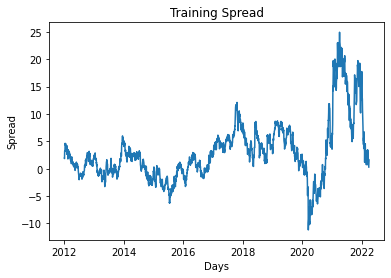

In [16]:
spread = prices['GM'] - hedge * prices['TM']

# Plot spread for training set


plt.plot(spread)
plt.ylabel(f"Spread")
plt.xlabel("Days")
plt.title(f"Training Spread");

#### 2.3 Creating z-scores based on training data
The z-scores will be used to execute the follow strategy:
- Short spread when z >= 2
- Long spread when z <= -2
- Close short when z <= 1
- Close long when z >= -1

In [17]:
mu = np.mean(spread.iloc[train])
std = np.std(spread.iloc[train])
zscore = (spread - mu) / std

## 3. Backtesting
Here, we test our strategy on both the test and training sets (even though the training results include look-ahead bias)

#### 3.1 Backtesting Using Exit and Entry Thresholds

In [18]:
# Adding positions to DataFrame

prices['LongGM'] = 0
prices['LongTM'] = 0
prices['ShortGM'] = 0
prices['ShortTM'] = 0
    
prices.loc[zscore >= 1, ('ShortGM', 'ShortTM')] = [-1, 1]

# Long spread
prices.loc[zscore <= -1, ('LongGM', 'LongTM')] = [1, -1]

# Exit short positions
prices.loc[zscore <= 0.5, ('ShortGM', 'ShortTM')] = 0

# Exit long positions
# Long spread
prices.loc[zscore >= -0.5, ('LongGM', 'LongTM')] = 0

# Ensure existing positions carried forward unless exit signal
prices.fillna(method='ffill', inplace=True)

In [19]:
# Finding positions for eachh day
long = prices.loc[:, ('LongGM', 'LongTM')]
short = prices.loc[:, ('ShortGM', 'ShortTM')]

positions = np.array(long) + np.array(short)
positions = pd.DataFrame(positions)

#### 3.2 Sharpe Ratio
Here, we calculate the Sharpe Ratio of the strategy on the training set. As this strategy does not trade frequently, we can ignore the risk-free rate in our calculations of the Sharpe ratio.

In [20]:
# Returns from training set
returns = prices.loc[:, ('GM', 'TM')].pct_change()

In [21]:
# Daily PnL based on our positions
pnl = np.array(positions.shift()) * np.array(returns)
pnl = pnl.sum(axis=1)

In [22]:
# Sharpe Ratio for training set
trainSharpe = np.sqrt(252) * np.mean(pnl[train][1:]) / np.std(pnl[train][1:])
print(f'Sharpe ratio for training set is {trainSharpe}')

# Sharpe ratio for test set
testSharpe = np.sqrt(252) * np.mean(pnl[test]) / np.std(pnl[test])
print(f'Out-of-sample Sharpe is {testSharpe}')

Sharpe ratio for training set is 1.550885438676403
Out-of-sample Sharpe is 0.44826330659903546


## 4. Optimal Holding Period (Ornstein-Uhlenbeck)
Another exit threshold we can employ is the holding period. In order to find the optimal holding period for our strategy, we employ the Ornstein-Uhlenbeck Formula to model our mean-reverting strategy to find the expected time for the spread to revert back to half its standard deviation. The formula is as shown:
$$dz(t) = -\theta(z(t) - \mu) + dW$$

After using Linear Regression to find the theta value, we can then calculate the half-life using:
$$\frac{ln(2)}{\theta}$$

In [23]:
# Find dz, the daily change of the spread
z = spread
prev_z = z.shift()
dz = z - prev_z

# Cleaning up NaN
dz = dz[1:,]
prev_z = prev_z[1:,]

In [24]:
# Finding theta
model2 = sm.OLS(dz, prev_z - np.mean(prev_z)).fit()
theta = model2. params[0]

In [25]:
# Half-life
halflife = - np.log(2) / theta
halflife

104.7677887394504

From the half-life approximation, our estimated optimal holding period should be ~100 days.

## 5. Future Considerations
- Using an appropriate lookback window to prevent look-ahead bias when testing our in-sample Sharpe.
- Optimising of entry and exit thresholds, while taking measures to prevent data-snooping bias.
- If more strategies are employed alongside this one, we make employ the Kelly formula to find optimal leverages for our portfolio.